# Detecting COVID-19 with Chest X Ray using PyTorch

Image classification of Chest X Rays in one of three classes: Normal, Viral Pneumonia, COVID-19

Notebook created for the guided project [Detecting COVID-19 with Chest X Ray using PyTorch](https://www.coursera.org/projects/covid-19-detection-x-ray) on Coursera

Dataset from [COVID-19 Radiography Dataset](https://www.kaggle.com/tawsifurrahman/covid19-radiography-database) on Kaggle

# Importing Libraries

In [1]:
%matplotlib inline

import os
import shutil
import random
import torch
import torchvision
import numpy as np

from PIL import Image
from matplotlib import pyplot as plt

torch.manual_seed(0)

print('Using PyTorch version', torch.__version__)

Using PyTorch version 1.5.1


# Preparing Training and Test Sets

In [2]:
class_names = ['normal', 'viral', 'covid']
root_dir = 'COVID-19 Radiography Database'
source_dirs = ['NORMAL', 'Viral Pneumonia', 'COVID-19']

if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
    os.mkdir(os.path.join(root_dir, 'test'))

    for i, d in enumerate(source_dirs):
        os.rename(os.path.join(root_dir, d), os.path.join(root_dir, class_names[i]))

    for c in class_names:
        os.mkdir(os.path.join(root_dir, 'test', c))

    for c in class_names:
        images = [x for x in os.listdir(os.path.join(root_dir, c)) if x.lower().endswith('png')]
        selected_images = random.sample(images, 30)
        for image in selected_images:
            source_path = os.path.join(root_dir, c, image)
            target_path = os.path.join(root_dir, 'test', c, image)
            shutil.move(source_path, target_path)

# Creating Custom Dataset

In [3]:
class chestxraydataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) if x.endswith('.png')]
            print(f"Found {len(images)} in {class_name} examples")
            return images
        
        self.images = {}
        self.class_names = ['normal', 'viral', 'covid']
        
        for i in self.class_names:
            self.images[i] = get_images(i)
            
        self.image_dirs = image_dirs
        self.transform = transform
        
    def __len__(self):
        return sum([len(self.images[i]) for i in self.class_names])
    
    def __getitem__(self, index):
        # To avaoid out-of-bound exception, we % with length
        class_name = random.choice(self.class_names)
        index = index % len(self.images[class_name])
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        # We convert the BnW to RGB
        image = Image.open(image_path).convert('RGB')
        return self.transform(image), self.class_names.index(class_name)

# Image Transformations

In [4]:
train_transform = torchvision.transforms.Compose([torchvision.transforms.Resize(size=(224, 224)),
                                                  torchvision.transforms.RandomHorizontalFlip(),
                                                  torchvision.transforms.ToTensor(),
                                                 torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                                 std=[0.229, 0.224, 0.225])])
test_transform = torchvision.transforms.Compose([torchvision.transforms.Resize(size=(224, 224)),
                                                  torchvision.transforms.ToTensor(),
                                                 torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                                 std=[0.229, 0.224, 0.225])])


# Prepare DataLoader

In [5]:
train_dirs = {
    'normal': 'COVID-19 Radiography Database/normal',
    'viral': 'COVID-19 Radiography Database/viral',
    'covid': 'COVID-19 Radiography Database/covid'
}

train_dataset = chestxraydataset(train_dirs, train_transform)

Found 1311 in normal examples
Found 1315 in viral examples
Found 189 in covid examples


In [6]:
test_dirs = {
    'normal': 'COVID-19 Radiography Database/test/normal',
    'viral': 'COVID-19 Radiography Database/test/viral',
    'covid': 'COVID-19 Radiography Database/test/covid'
}

test_dataset = chestxraydataset(test_dirs, test_transform)

Found 30 in normal examples
Found 30 in viral examples
Found 30 in covid examples


In [7]:
bs = 5
dataloader_train = torch.utils.data.DataLoader(train_dataset, batch_size=bs, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(test_dataset, batch_size=bs, shuffle=True)

print(f"Length of train loader: {len(dataloader_train)}")
print(f"Length of test loader: {len(dataloader_test)}")

Length of train loader: 563
Length of test loader: 18


# Data Visualization

In [8]:
class_names = train_dataset.class_names

def show_images(images, labels, preds):
    plt.figure(figsize=(8,4))
    for i, image in enumerate(images):
        plt.subplot(1, 5, i+1, xticks=[], yticks=[])  # 1 row 5 cols
        image = image.numpy().transpose((1,2,0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image*std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        colour = 'green' if preds[i] == labels[i] else 'red'
        
        plt.xlabel(f"{class_names[int(labels[i].numpy())]}")
        plt.ylabel(f"{class_names[int(preds[i].numpy())]}", color=colour)
        
    plt.show()

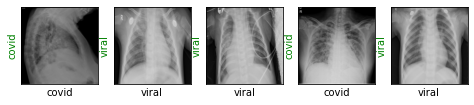

In [9]:
images, labels = next(iter(dataloader_train))
show_images(images, labels, labels)

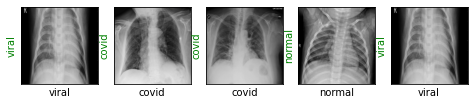

In [10]:
images, labels = next(iter(dataloader_test))
show_images(images, labels, labels)

# Creating the Model

In [11]:
model = torchvision.models.resnet50(pretrained=True)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [12]:
model.fc = torch.nn.Linear(in_features=2048, out_features=3)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-5)

In [13]:
def show_preds():
    model.eval()
    images, labels = next(iter(dataloader_test))
    output = model(images)
    values, preds = torch.max(output, 1) # dim=0 is no. of examples, hence dim=1
    show_images(images, labels, preds)

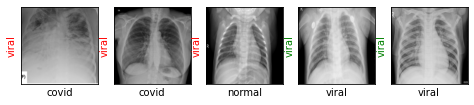

In [14]:
show_preds()

# Training the Model

In [25]:
def train(epochs):
    print('Starting training...')
    for e in range(epochs):
        print(f"Epoch {e+1}/{epochs}")
        
        train_loss = 0
        model.train()
        for train_step, (img, lbl) in enumerate(dataloader_train):
            # Refresh the optimizer and set gradient to 0
            optimizer.zero_grad()
            output = model(img)
            loss = loss_fn(output, lbl)
            # Backpropagate and update gradient step
            loss.backward()
            optimizer.step()
            
            train_loss ++ loss.item()
            if train_step % 20 ==0:
                print('Evaluating at step',train_step, end=" ")
                acc = 0
                val_loss = 0
                model.eval()
                
                for val_step, (img, lbl) in enumerate(dataloader_test):
                    output = model(img)
                    loss = loss_fn(output, lbl)
                    val_loss += loss.item()
                    
                    _, preds = torch.max(output, 1)
                    acc += sum((preds == lbl).numpy())
                val_loss /= (val_step + 1)
                acc /= len(test_dataset)
                print(f"Val Loss: {100*val_loss:.2f}%, Accuracy: {100*acc:.2f}%")
                #show_preds()
                
                model.train()
                if acc > 0.95:
                    print("Performance maximum point acheived!!")
                    print("*"*20)
                    show_preds()
                    return
        train_loss /= (train_step + 1)
        print(f"Training Loss: {100*train_loss:.2f}")

Starting training...
Epoch 1/5
Evaluating at step 0 Val Loss: 62.87%, Accuracy: 93.33%
Evaluating at step 20 Val Loss: 29.86%, Accuracy: 94.44%
Evaluating at step 40 Val Loss: 19.59%, Accuracy: 97.78%
Performance maximum point acheived!!
********************


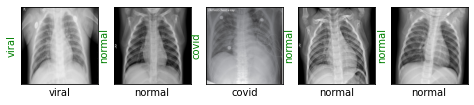

In [26]:
epoch = 5
train(epoch)

# Final Results

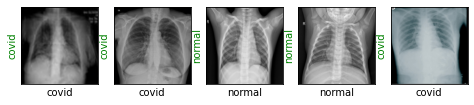

In [27]:
show_preds()